In [202]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor, NeighborhoodComponentsAnalysis
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder
from sklearn.metrics import r2_score, f1_score, mean_squared_error, mean_absolute_error, accuracy_score, recall_score, precision_score, confusion_matrix

import warnings
warnings.filterwarnings('ignore')

### Предобработка и оценка данных
!!!Повторяет то что было в регрессии

In [182]:
houses_raw_df = pd.read_csv('houses.csv', sep=',', index_col='Id')
houses_raw_df.sample(5)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
517,80,RL,NaN,10448,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,GdPrv,NaN,0,8,2009,COD,Abnorml,158000
669,20,RL,NaN,14175,Pave,NaN,Reg,Bnk,AllPub,Corner,...,0,NaN,NaN,NaN,0,11,2006,WD,Normal,168000
1060,50,RL,NaN,11275,Pave,NaN,IR1,HLS,AllPub,Corner,...,0,NaN,NaN,NaN,0,3,2007,WD,Normal,220000
404,60,RL,93.0,12090,Pave,NaN,Reg,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,7,2006,WD,Abnorml,258000
1275,50,RL,53.0,5362,Pave,NaN,Reg,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,11,2007,WD,Normal,139000


In [183]:
print(
    f"Sample dimensionality: {houses_raw_df.shape}",
    f"Has {len(houses_raw_df[houses_raw_df.duplicated()])} row duplicates",
    f"Has id {len(houses_raw_df[houses_raw_df.index.duplicated()])} duplicates",
    f"Has {len(houses_raw_df[houses_raw_df['SalePrice'].isna()])} regression target `SalePrice` skips",
    f"Has {len(houses_raw_df[houses_raw_df['OverallCond'].isna()])} classification target `OverallCond` skips",
    sep="\n"
)

Sample dimensionality: (1460, 80)
Has 0 row duplicates
Has id 0 duplicates
Has 0 regression target `SalePrice` skips
Has 0 classification target `OverallCond` skips


In [184]:
# Удалим признаки для которых много пропусков
_to_remove = houses_raw_df.columns[houses_raw_df.count() < 800]
houses_raw_df.drop(_to_remove, axis=1, inplace=True)

houses_raw_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1460 entries, 1 to 1460
Data columns (total 74 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   LotShape       1460 non-null   object 
 6   LandContour    1460 non-null   object 
 7   Utilities      1460 non-null   object 
 8   LotConfig      1460 non-null   object 
 9   LandSlope      1460 non-null   object 
 10  Neighborhood   1460 non-null   object 
 11  Condition1     1460 non-null   object 
 12  Condition2     1460 non-null   object 
 13  BldgType       1460 non-null   object 
 14  HouseStyle     1460 non-null   object 
 15  OverallQual    1460 non-null   int64  
 16  OverallCond    1460 non-null   int64  
 17  YearBuilt      1460 non-null   int64  
 18  YearRemodAdd 

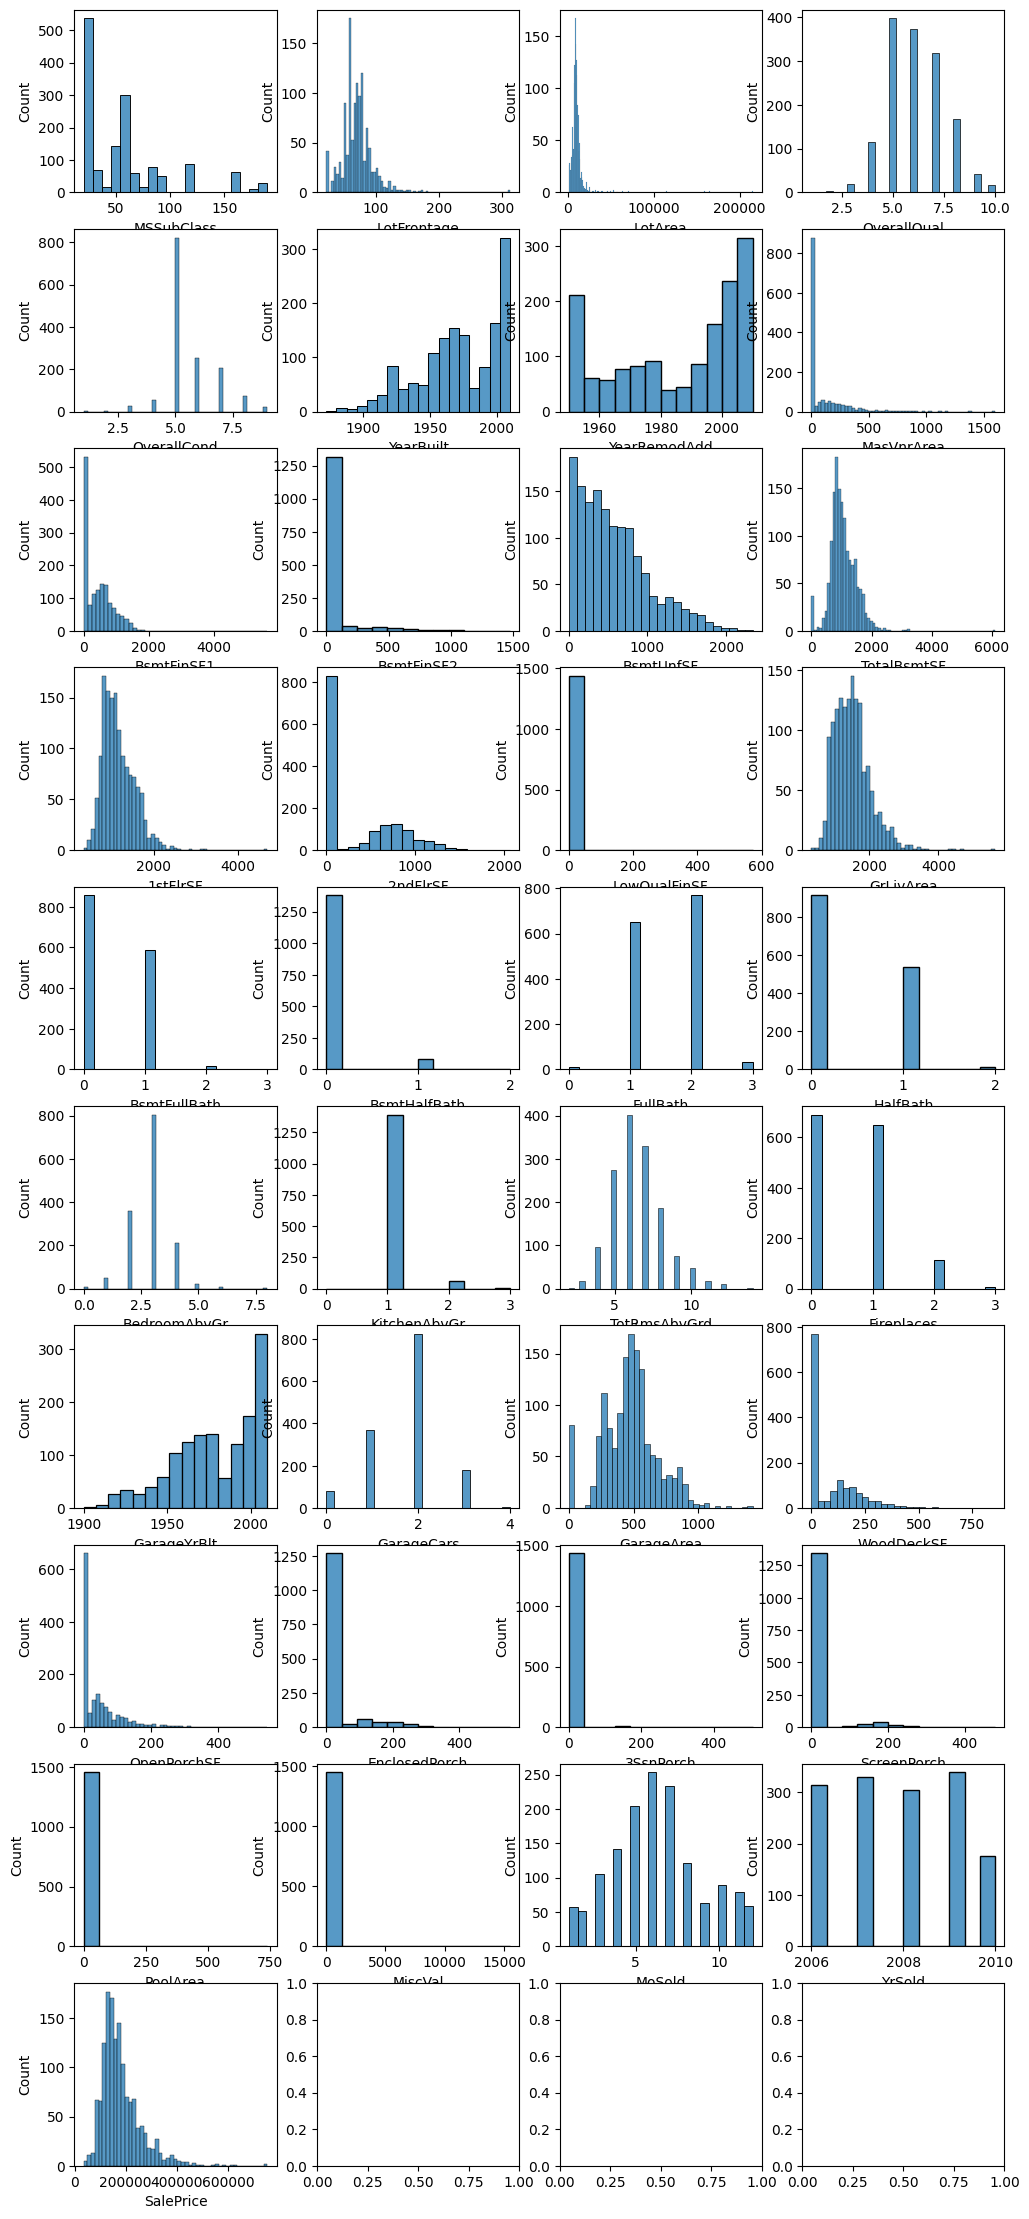

In [185]:
def check_for_quality_number_scales():
    number_cols = houses_raw_df.select_dtypes(include='number').columns

    _columns = 4
    _rows = int(np.ceil(len(number_cols) / _columns))

    fig, ax = plt.subplots(nrows=_rows, ncols=_columns, figsize=(12, 28))
    ax = ax.flatten()

    for idx, number_col in enumerate(number_cols): # Есть качественные шкалы которые лучше преобразовать к категориальным
        sns.histplot(
            houses_raw_df,
            x=houses_raw_df[number_col],
            ax=ax[idx]
        )
    
check_for_quality_number_scales() # Нужно преобразовать  качественные шкалы к категориальным

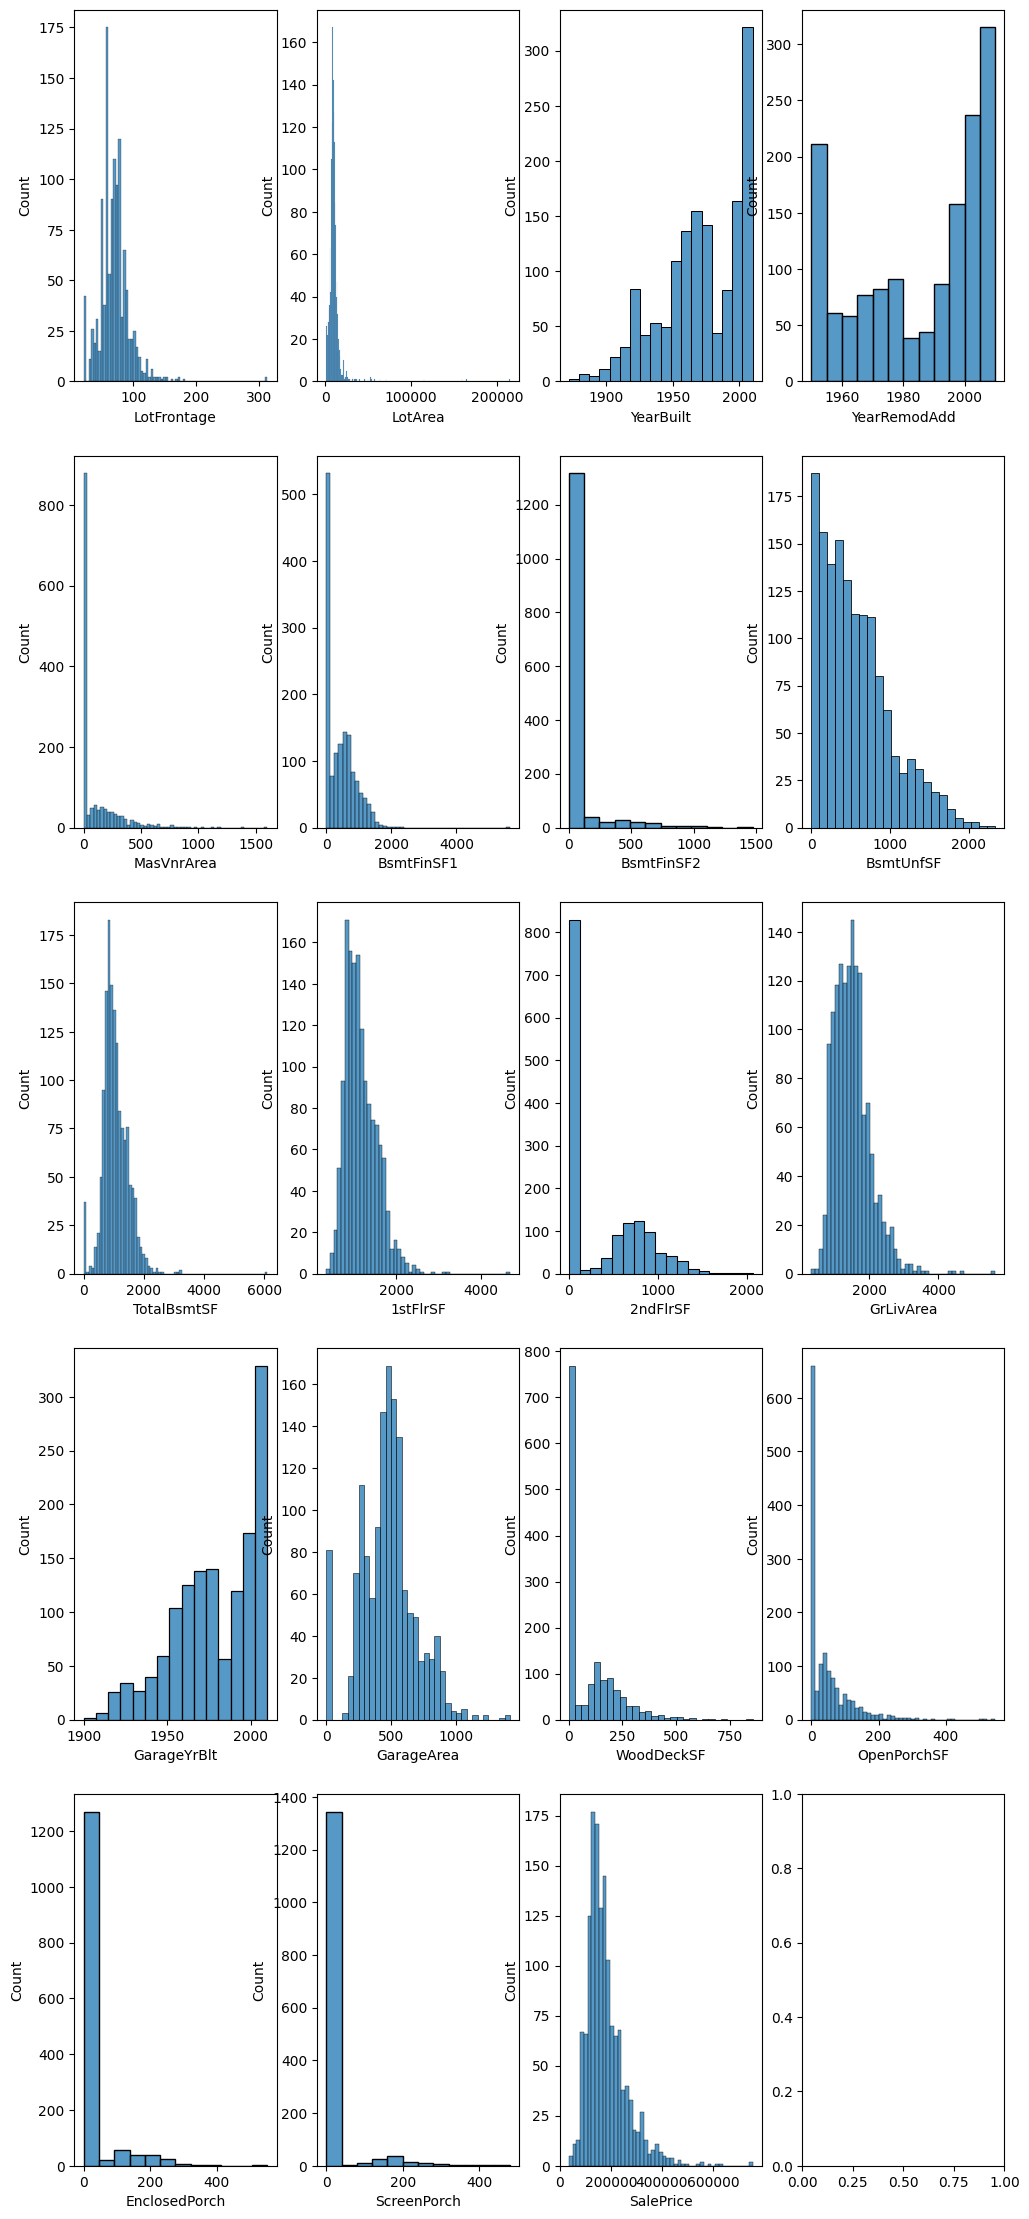

In [186]:
to_cat = []
for column in houses_raw_df.select_dtypes(include='number').columns:
    if len(houses_raw_df[column].value_counts().index) < 25:
        to_cat.append(column)
        
for quality_col in to_cat:
    houses_raw_df[quality_col] = houses_raw_df[quality_col].astype(object)
check_for_quality_number_scales() # Выглядит криво, но стало лучше

# Также можем заметтить, что есть много распределений где поможет чистка от выбросов или логарифмирование

In [187]:
# Удалим бесполезные категориальные признаки
for cat_col in houses_raw_df.select_dtypes(exclude='number').columns:
    _overall = houses_raw_df[cat_col].count()
    _most_samples = houses_raw_df[cat_col].value_counts().iloc[0]
    _coef = _most_samples / _overall
    if _coef > 0.9:
        print(f"removing feature {cat_col}, coef f{_coef}")
        houses_raw_df.drop(cat_col, axis=1, inplace=True)


removing feature Street, coef f0.9958904109589041
removing feature Utilities, coef f0.9993150684931507
removing feature LandSlope, coef f0.9465753424657535
removing feature Condition2, coef f0.9897260273972602
removing feature RoofMatl, coef f0.9821917808219178
removing feature BsmtCond, coef f0.921293042867182
removing feature Heating, coef f0.9780821917808219
removing feature CentralAir, coef f0.934931506849315
removing feature Electrical, coef f0.914324880054832
removing feature LowQualFinSF, coef f0.9821917808219178
removing feature BsmtHalfBath, coef f0.9438356164383561
removing feature KitchenAbvGr, coef f0.9534246575342465
removing feature Functional, coef f0.9315068493150684
removing feature GarageQual, coef f0.9506889050036258
removing feature GarageCond, coef f0.9615663524292966
removing feature PavedDrive, coef f0.9178082191780822
removing feature 3SsnPorch, coef f0.9835616438356164
removing feature PoolArea, coef f0.9952054794520548
removing feature MiscVal, coef f0.9643835

In [188]:
NUM_COLS = houses_raw_df.select_dtypes(include='number').columns
CAT_COLS = houses_raw_df.select_dtypes(exclude='number').columns

## Classification

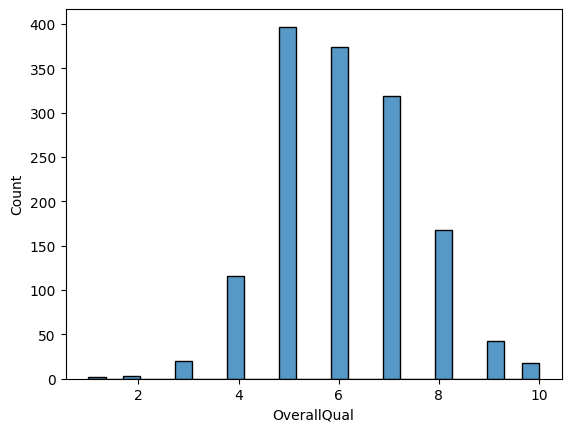

In [189]:
# Посмотрим как выглядит распределение целевой переменной. 
CLASSIFICATION_TARGET = "OverallQual"
sns.histplot( 
    houses_raw_df,
    x=CLASSIFICATION_TARGET
)

classification_df = houses_raw_df.copy()

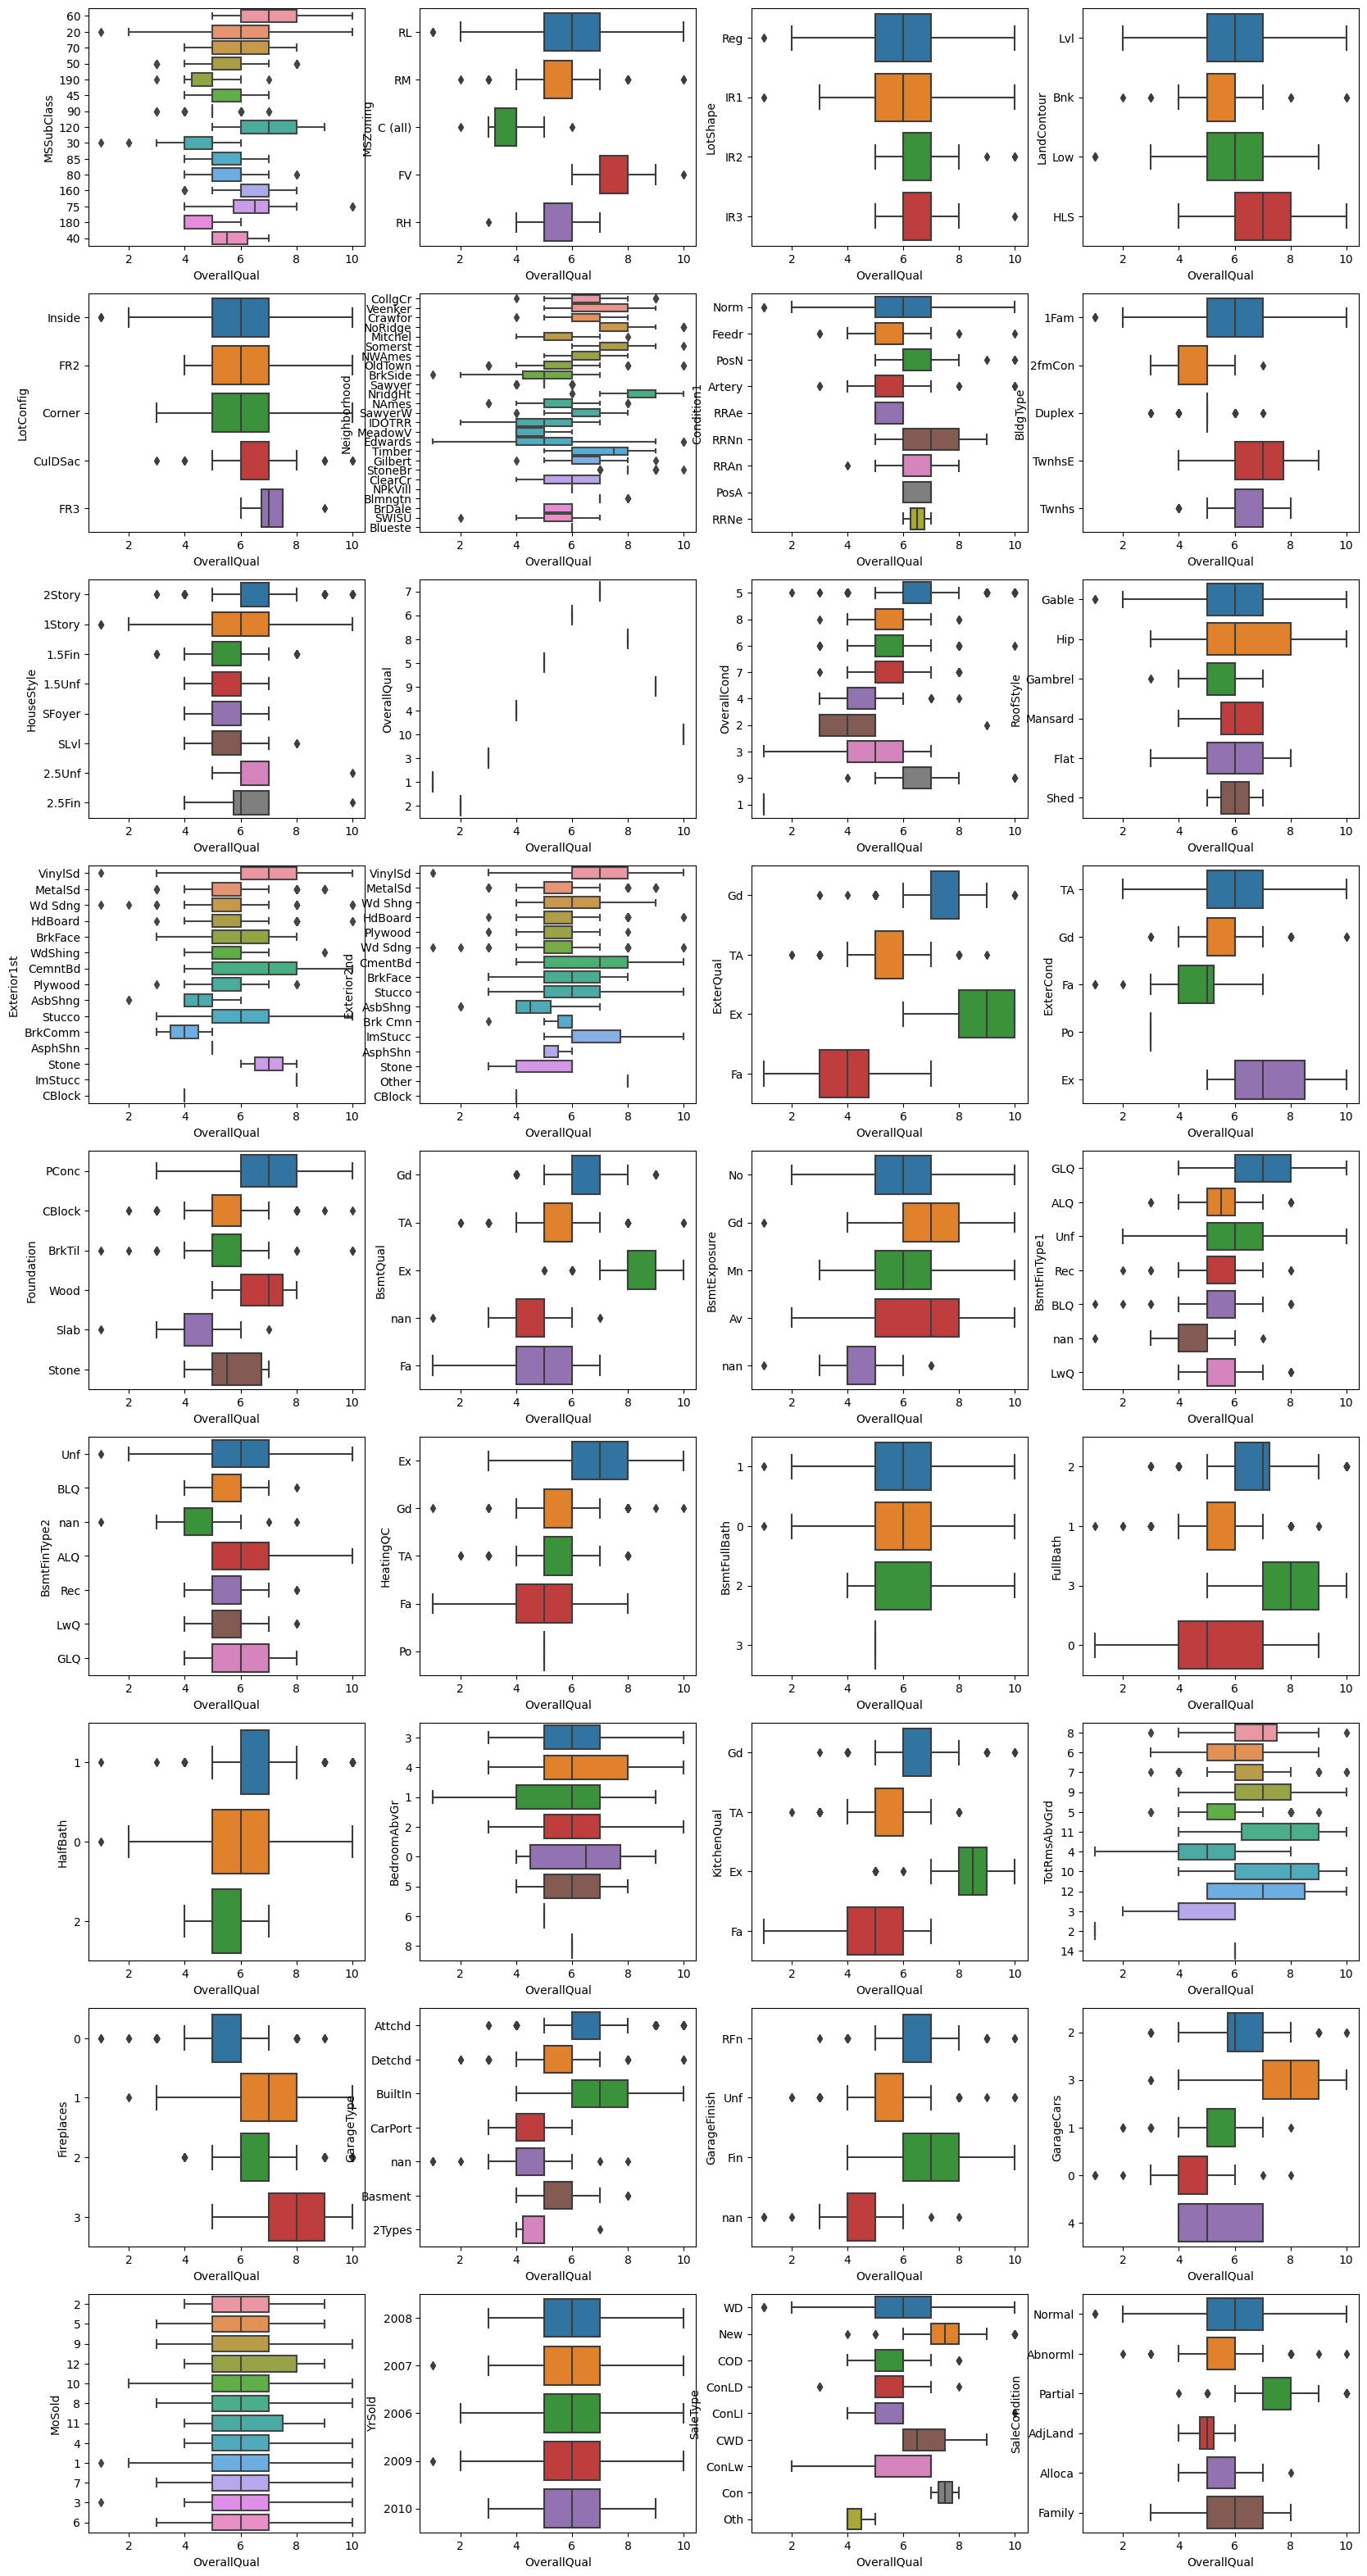

In [190]:
# Посмотрим вариативность каких категориальных признаков не имеет особо значения

_cols = 4
_rows = int(np.ceil(len(CAT_COLS) / _cols))
fig, ax = plt.subplots(nrows=_rows, ncols=_cols, figsize=(20, 40))
ax = ax.flatten()

for idx, cat_col in enumerate(CAT_COLS): # Есть относительно бесплезные признаки, котоыре не влияют на цену. Удалим их
    sns.boxplot(
        classification_df,
        x=classification_df[CLASSIFICATION_TARGET],
        y=classification_df[cat_col].astype(str),
        ax=ax[idx],
    )

# Исходим из предположения что, признаки где практически все значения одинаковые не помогут в классификации.
# Исходя из этого можно удалить многие признаки. Этим и займемся. Как делать это автоматом я не знаю, поэтмоу удалю руками
classification_df.drop([
    "YrSold", "MSSubClass", "LotConfig", "RoofStyle", "HouseStyle", "LotShape", 
    "Exterior1st", "Exterior2nd", "BsmtFullBath", "BedroomAbvGr", "HalfBath", 
    "BsmtFinType2", "MoSold", "YrSold"
    ],
                       axis=1, inplace=True)

# Еще раз извиняюсь за кол-во графиков

In [191]:
# Объединим редкие признаки в один

# for cat_col in classification_df.select_dtypes(exclude='number').columns.drop(CLASSIFICATION_TARGET):
#     index = classification_df[cat_col].value_counts().index
#     to_merge = classification_df[cat_col].value_counts() < 25
#     to_merge = index[to_merge]
    
#     classification_df[cat_col] = classification_df[cat_col].apply(lambda v: "other" if v in to_merge else v)

In [196]:
# Создадим пайплайн

num_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()), # StandardScaler or MinMaxScaler
    ('NCA', NeighborhoodComponentsAnalysis(n_components=8))
])

cat_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("one_hot", OneHotEncoder(drop="if_binary", handle_unknown="ignore", sparse=False))
])

preprocessors = ColumnTransformer(transformers=[
    ("num", num_pipe, classification_df.select_dtypes(include="number").columns),
    ("cat", cat_pipe, classification_df.select_dtypes(exclude="number").columns.drop(CLASSIFICATION_TARGET))
])

model_pipe = Pipeline([
    ("preprocessing", preprocessors),
    ("model", KNeighborsClassifier(n_neighbors=13, weights="distance"))
])

In [211]:
X_train, X_test, y_train, y_test = train_test_split(
    classification_df.drop(CLASSIFICATION_TARGET, axis=1),
    classification_df[CLASSIFICATION_TARGET],
    test_size=0.2,
    random_state=43,
    stratify=classification_df[CLASSIFICATION_TARGET]
)
# classification_df[CLASSIFICATION_TARGET].value_counts().index

In [219]:
def classification_metrics(model_pipe, X_test, y_test):
    y_hat = model_pipe.predict(X_test)
    avg = "micro"
    print("f1_score: ", f1_score(y_test, y_hat, average=avg))
    print("accuracy: ", accuracy_score(y_test, y_hat))
    print("precision: ", precision_score(y_test, y_hat, average=avg))
    print("recall: ", recall_score(y_test, y_hat, average=avg))
    confusion_matrix(y_test, y_hat)

In [221]:
model_pipe.fit(X_train, y_train.astype('int'))
classification_metrics(model_pipe, X_test, y_test.astype('int'))
# Не очень хорошие показатели(
# Предполагаю что сложно отличить 5 от 6, 6 от 7 и тд тп

f1_score:  0.5205479452054794
accuracy:  0.5205479452054794
precision:  0.5205479452054794
recall:  0.5205479452054794


In [222]:
param_grid = {
    "preprocessing__num__NCA__n_components": np.arange(6, 15, 3),
    "model__n_neighbors": np.arange(10, 30, 5),
}
pipe_gs = GridSearchCV(estimator=model_pipe,
                       param_grid=param_grid,
                       cv=KFold(n_splits=5))

In [223]:
pipe_gs.fit(X_train, y_train.astype(int))

GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          StandardScaler()),
                                                                                         ('NCA',
                                                                                          NeighborhoodComponentsAnalysis(n_components=8))]),
                                                                         Index(['LotFrontage', 'LotArea', 'YearBuilt', 'YearRemodAdd...
       'BsmtExposure', 'BsmtFinType1', 'HeatingQC', 'FullBath', 'KitchenQual',
       'TotRmsAbvGrd', 'Fireplaces', 'GarageType', 'GarageFinish',
       'GarageCars', 'SaleType', 'SaleCondition'],
      dtype='object'))])),
                                       ('model',
                                        KNeighborsClassifier(n_neighbors=13,
                                                             weights='distance'))]),
             param_grid={'model__n_neighbors': array([10, 15, 20, 25]),
                         'preprocessing__num__NCA__n_components': array([ 6,  9, 12])})

In [224]:
best_estimator = pipe_gs.best_estimator_
classification_metrics(best_estimator, X_test, y_test.astype(int)) # Совсем чуть чуть лучше

f1_score:  0.5547945205479452
accuracy:  0.5547945205479452
precision:  0.5547945205479452
recall:  0.5547945205479452


In [236]:
pipe_gs.best_estimator_.get_params()["model"] # Логично

KNeighborsClassifier(n_neighbors=15, weights='distance')

In [237]:
best_estimator.get_params()["preprocessing__num__NCA"] # Ожидаемо

NeighborhoodComponentsAnalysis(n_components=12)

In [234]:
# Взглянем в чем дело

y_hat = best_estimator.predict(X_test)

def highlight(df):
    attrs = pd.DataFrame('', index=df.index, columns=df.columns)
    
    for index in df.index:
        for col in df.columns:
            if index == col:
                attrs.loc[index, col] = "background: green"
            elif df.loc[index, col] > 5:
                attrs.loc[index, col] = "background: red"
    return attrs

cross_tab = pd.crosstab(y_test, columns=[y_hat], rownames=["Метки"], colnames=["Предсказания"])
cross_tab.style.apply(highlight, axis=None)

# Частично можно подтвердить классификатору сложно отличить соседние классы. 
# Думаю можно было бы объединить классы сократив их в 2 раза, тогда модель выдала бы лучший результат

Предсказания,3,4,5,6,7,8,9,10
Метки,,,,,,,,
2,0,1,0,0,0,0,0,0
3,0,1,3,0,0,0,0,0
4,1,2,12,8,0,0,0,0
5,0,7,49,21,2,0,0,0
6,0,1,24,40,10,0,0,0
7,0,0,1,8,45,9,1,0
8,0,0,0,1,7,23,2,0
9,0,0,0,0,0,4,3,2
10,0,0,0,0,0,3,1,0


#### Выводы
1. NCA особо не повлиял на качество метрик
2. В целом модельно не плохо классифицирует.
3. Думаю объединение целевой переменной в меньшое кол-во классов помогло бы